In [7]:
from model import SugarscapeCg
from agents import Cop, Criminal

from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner, BatchRunnerMP

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import datetime

## Helper functions

In [10]:
def run_model(model):
    model.run_model()

    output = model.datacollector.get_model_vars_dataframe()
    #print(output)

    return output

In [11]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [12]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [62]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    avg_crimes_per_distr_dict = {'Centrum': 0, 'Nieuw-West': 0, 'Noord': 0, 'Oost': 0, 'West': 0, 'Zuid': 0, 'Zuidoost': 0} 
    confidence_bounds = dict()
    means_dict_for_ci = {}
    
    for i in range(len(outputs)):
        for district in district_names:
            district_mean = np.mean(outputs[i].iloc[burn_in:][district])
            avg_crimes_per_distr_dict[district] += district_mean
            if district in means_dict_for_ci.keys():
                means_dict_for_ci[district].append(district_mean)
            else:
                means_dict_for_ci[district] = [district_mean]
          
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    avg_crimes_per_distr_dict = dict(sorted(avg_crimes_per_distr_dict.items(), key=lambda item:item[1]))
    
    
    for district in avg_crimes_per_distr_dict.keys():
        confidence_bounds[district] = 1.96*np.std(means_dict_for_ci[district])/len(means_dict_for_ci[district])
    return avg_crimes_per_distr_dict, confidence_bounds

## Plotting functions

In [14]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [15]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [16]:
# def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
#     plt.bar(np.arange(len(district_means)), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
#     plt.xticks(np.arange(len(district_means)), district_names)
#     # plt.xlabel("Number of steps")
#     plt.ylabel('Number of crimes')

In [60]:
def plot_district_means_bar(avg_crimes_per_distr_dict, district_colors,confidence_bounds):
    plt.bar(avg_crimes_per_distr_dict.keys(), avg_crimes_per_distr_dict.values(), yerr=confidence_bounds.values(), color=district_colors)
    plt.legend()
    plt.show()
    return

In [41]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Sensitivity Analysis

In [11]:
# We define our variables and bounds
problem = {
    'num_vars': 5,
    'names': ['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'],
    'bounds': [[0, 20], [1, 10], [1, 10], [0, 500], [0, 100]]
}

# Set the outputs
model_reporters = {
    "Total crimes": lambda m: m.schedule.get_crimes_commited(), 
    "Criminals in jail": lambda m: m.schedule.get_criminal_count_in_jail(),
    # "Centrum": lambda m: m.get_crimes_per_district()['Centrum'],
    # "Noord": lambda m: m.get_crimes_per_district()['Noord'],
    # "West": lambda m: m.get_crimes_per_district()['West'],
    # "Zuid": lambda m: m.get_crimes_per_district()['Zuid'],
    # "Zuidoost": lambda m: m.get_crimes_per_district()['Zuidoost'],
    # "Oost": lambda m: m.get_crimes_per_district()['Oost'],
    # "Nieuw-West": lambda m: m.get_crimes_per_district()['Nieuw-West'],
    "Centrum": lambda m:m.schedule.update_average_crimes_per_timestep("Centrum").get("Centrum"),
    "Noord": lambda m:m.schedule.update_average_crimes_per_timestep("Noord").get("Noord"),
    "West": lambda m:m.schedule.update_average_crimes_per_timestep("West").get("West"),
    "Zuid": lambda m:m.schedule.update_average_crimes_per_timestep("Zuid").get("Zuid"),
    "Zuidoost": lambda m:m.schedule.update_average_crimes_per_timestep("Zuidoost").get("Zuidoost"),
    "Oost": lambda m:m.schedule.update_average_crimes_per_timestep("Oost").get("Oost"),
    "Nieuw-West": lambda m:m.schedule.update_average_crimes_per_timestep("Nieuw-West").get("Nieuw-West")
}
# model_reporters = {"Data Collector": lambda m: m.datacollector},

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 1#10
max_steps = 300#200
distinct_samples = 500#500

param_values = saltelli.sample(problem, N=distinct_samples, calc_second_order=False)

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (500) is equal to `2^n`.
        
  warnings.warn(msg)


In [12]:
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['jail_sentence', 'criminal_risk_radius', 'cop_catch_radius', 'criminal_risk_aversion', 'criminal_disconnectivity'])
data['Run'], data['Centrum'], data['Criminals in jail'] = None, None, None
data['Nieuw-West'], data['Noord'], data['Oost'], data['Total crimes'], data['West'], data['Zuid'], data['Zuidoost'] = None, None, None, None, None, None, None

# print(data)

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals = [int(item) for item in vals]
        # print(vals)
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        # print(variable_parameters)

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = int(count) # Don't know what causes this, but iteration number is not correctly filled
        # print(iteration_data)

        data.iloc[count, :len(problem['names'])] = vals  # fills in varied parameter (this has to span more columns when more than 1 parameter is varied)
        data.iloc[count, len(problem['names']):] = iteration_data  # fills in output data (in this case just 'Run' and 'Crimes')
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [13]:
print(data)

ct = datetime.datetime.now()
filename = 'sensitivity_analysis_output_' + str(ct)
data.to_csv(filename)

     jail_sentence criminal_risk_radius cop_catch_radius  \
0                0                    3                9   
1               11                    3                9   
2                0                    6                9   
3                0                    3                9   
4                0                    3                9   
...            ...                  ...              ...   
3495             6                    2                8   
3496             6                    9                6   
3497             6                    9                8   
3498             6                    9                8   
3499             0                    2                6   

     criminal_risk_aversion criminal_disconnectivity     Run   Centrum  \
0                       495                       45     0.0  4.651775   
1                       495                       45     1.0   1.84575   
2                       495                       45     

In [14]:
Si_crimes = sobol.analyze(problem, data['Total crimes'].values, calc_second_order=False, print_to_console=True)
Si_jail = sobol.analyze(problem, data['Criminals in jail'].values, calc_second_order=False, print_to_console=True)
Si_centrum = sobol.analyze(problem, data['Centrum'].values, calc_second_order=False, print_to_console=True)
Si_noord = sobol.analyze(problem, data['Noord'].values, calc_second_order=False, print_to_console=True)
Si_west = sobol.analyze(problem, data['West'].values, calc_second_order=False, print_to_console=True)
Si_zuid = sobol.analyze(problem, data['Zuid'].values, calc_second_order=False, print_to_console=True)
Si_zuidoost = sobol.analyze(problem, data['Zuidoost'].values, calc_second_order=False, print_to_console=True)
Si_oost = sobol.analyze(problem, data['Oost'].values, calc_second_order=False, print_to_console=True)
Si_nieuw_west = sobol.analyze(problem, data['Nieuw-West'].values, calc_second_order=False, print_to_console=True)

                                ST   ST_conf
jail_sentence             0.786132  0.096414
criminal_risk_radius      0.951254  0.105969
cop_catch_radius          0.884310  0.102985
criminal_risk_aversion    0.896681  0.105324
criminal_disconnectivity  0.910133  0.096371
                                S1   S1_conf
jail_sentence             0.096491  0.101278
criminal_risk_radius     -0.060973  0.117244
cop_catch_radius         -0.048227  0.107323
criminal_risk_aversion   -0.021644  0.111313
criminal_disconnectivity  0.089783  0.115717
                                ST   ST_conf
jail_sentence             0.826887  0.106878
criminal_risk_radius      0.975964  0.089255
cop_catch_radius          0.909987  0.099809
criminal_risk_aversion    0.943074  0.106552
criminal_disconnectivity  0.892184  0.107961
                                S1   S1_conf
jail_sentence             0.051021  0.109023
criminal_risk_radius     -0.084972  0.108059
cop_catch_radius         -0.045083  0.114110
criminal_r

{'S1': array([ 0.09649074, -0.06097262, -0.04822678, -0.02164404,  0.0897828 ]), 'S1_conf': array([0.10127786, 0.11724392, 0.10732311, 0.11131266, 0.11571726]), 'ST': array([0.78613239, 0.95125354, 0.88430956, 0.89668113, 0.91013291]), 'ST_conf': array([0.09641367, 0.10596941, 0.10298458, 0.10532448, 0.09637121])}


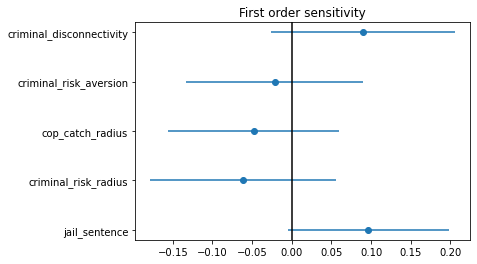

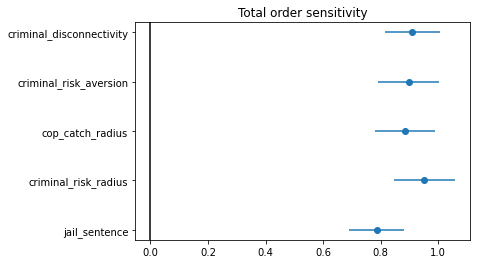

{'S1': array([ 0.05102075, -0.08497154, -0.04508335, -0.03788469,  0.04330603]), 'S1_conf': array([0.10902278, 0.10805917, 0.11411029, 0.1119565 , 0.12062514]), 'ST': array([0.82688655, 0.97596354, 0.90998694, 0.943074  , 0.89218412]), 'ST_conf': array([0.10687774, 0.08925548, 0.09980902, 0.10655249, 0.10796081])}


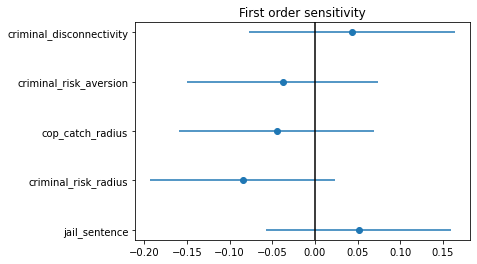

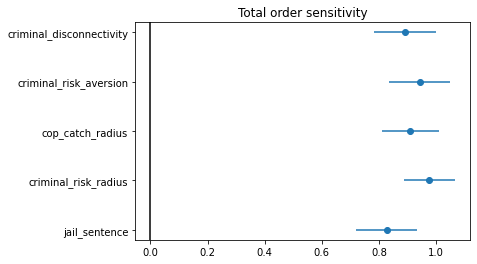

{'S1': array([ 0.01168593, -0.05526352, -0.10186123,  0.01358384,  0.14707474]), 'S1_conf': array([0.09747186, 0.10314804, 0.11055081, 0.10043576, 0.12241733]), 'ST': array([0.91763691, 1.10791021, 1.08400863, 0.88240989, 1.00530493]), 'ST_conf': array([0.17539232, 0.24482114, 0.22447401, 0.21084354, 0.21559539])}


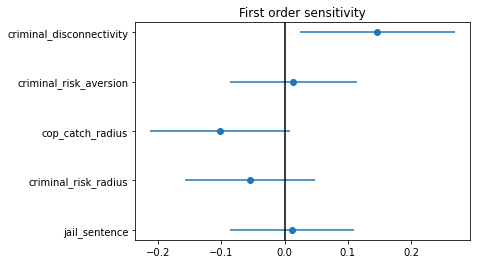

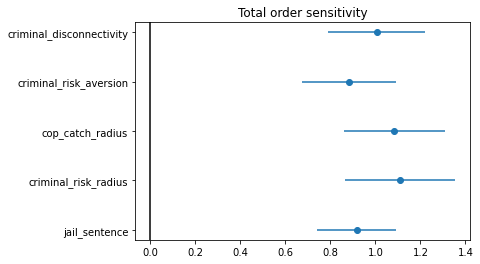

{'S1': array([ 0.04684117, -0.08071556, -0.06327254, -0.02356864,  0.03673912]), 'S1_conf': array([0.11993399, 0.10334638, 0.1008426 , 0.10314241, 0.12062653]), 'ST': array([0.92359599, 0.94840982, 0.79816698, 0.89229348, 0.92123065]), 'ST_conf': array([0.13184492, 0.12922175, 0.11762505, 0.15375588, 0.12230325])}


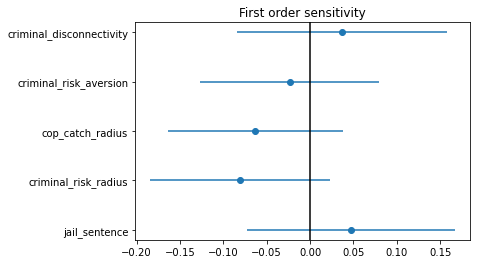

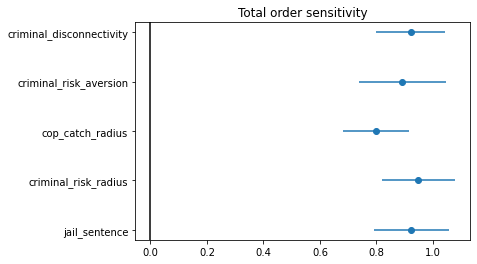

{'S1': array([0.13541129, 0.13853442, 0.06730174, 0.08764957, 0.16833177]), 'S1_conf': array([0.13378209, 0.10026419, 0.11082973, 0.12925614, 0.10624632]), 'ST': array([0.94976841, 0.96284435, 0.88983186, 0.91988064, 0.93109718]), 'ST_conf': array([0.17097065, 0.18257127, 0.1513261 , 0.19788353, 0.1648141 ])}


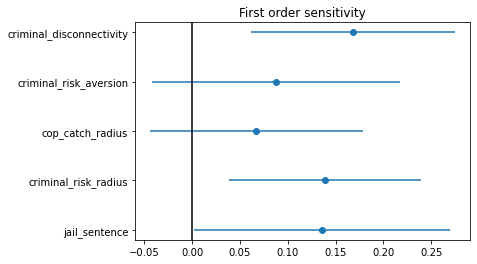

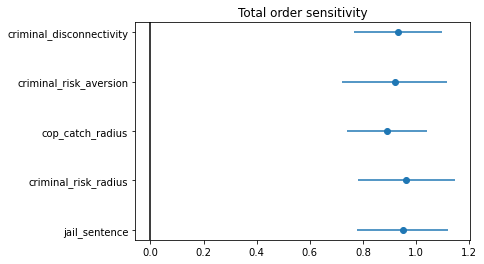

{'S1': array([ 0.05991271,  0.01210916, -0.02318815, -0.07916167,  0.09708679]), 'S1_conf': array([0.1163067 , 0.12669783, 0.11458537, 0.11926205, 0.11149281]), 'ST': array([0.82610487, 1.04367599, 0.94959851, 0.9568578 , 0.98350149]), 'ST_conf': array([0.10547343, 0.13276674, 0.12813261, 0.13274692, 0.12138663])}


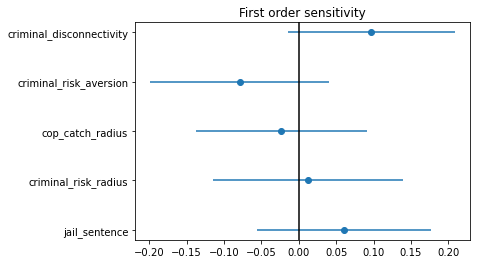

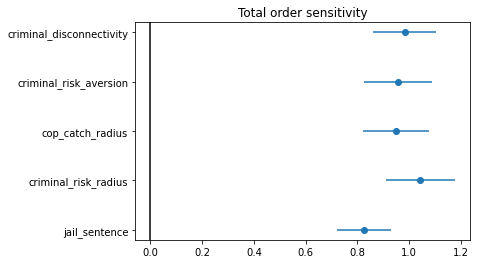

{'S1': array([ 0.02316309, -0.07525921, -0.05831294, -0.06473538,  0.09707587]), 'S1_conf': array([0.12874168, 0.10452717, 0.13194988, 0.11543238, 0.13794851]), 'ST': array([0.84072887, 0.92616131, 0.85780139, 0.93280068, 0.92583583]), 'ST_conf': array([0.10496072, 0.11084326, 0.13012185, 0.13074644, 0.10636085])}


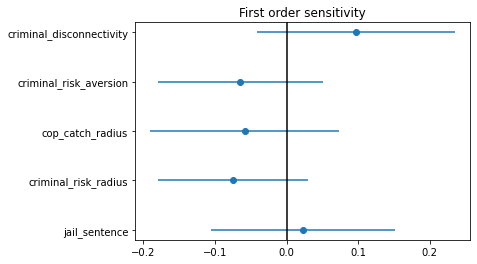

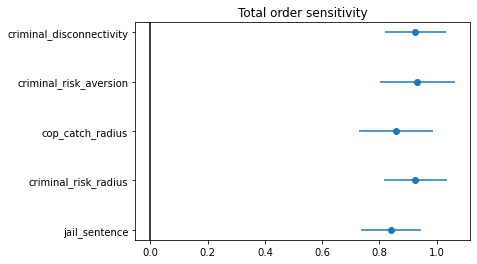

{'S1': array([ 0.01341225, -0.08654289, -0.047023  , -0.0542484 ,  0.06184427]), 'S1_conf': array([0.13233682, 0.11829694, 0.10733034, 0.12046066, 0.13295313]), 'ST': array([0.80883062, 0.83998754, 0.75877345, 0.84666124, 0.90569617]), 'ST_conf': array([0.10977748, 0.11392518, 0.11305608, 0.11339094, 0.12182225])}


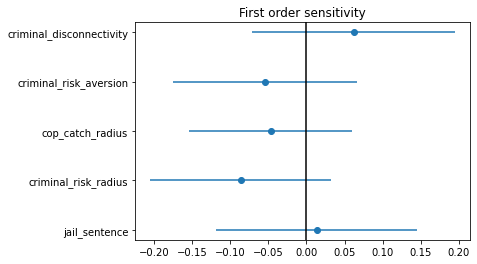

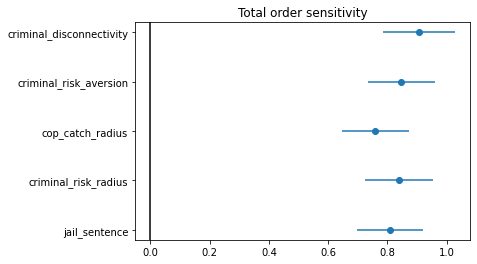

{'S1': array([ 0.08577756, -0.0906747 , -0.10078942, -0.00811029,  0.06465842]), 'S1_conf': array([0.11227329, 0.11772832, 0.10570474, 0.10850967, 0.12924124]), 'ST': array([0.77300963, 0.9883917 , 0.89273865, 0.88518361, 0.88878406]), 'ST_conf': array([0.10111888, 0.11123385, 0.11132905, 0.10629981, 0.10265636])}


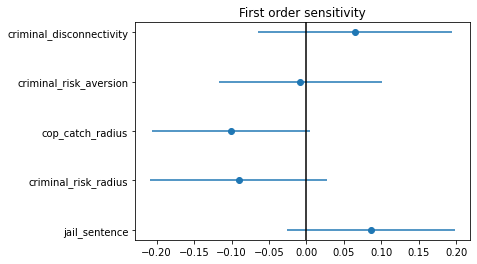

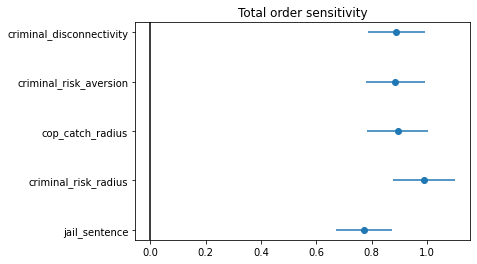

In [15]:
for Si in (Si_crimes, Si_jail, Si_centrum, Si_noord, Si_west, Si_zuid, Si_zuidoost, Si_oost, Si_nieuw_west):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Run model

In [18]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

## Criminal disconnectivity experiment

In [53]:
num_runs = 2
outputs = []
output_dict = {}

criminal_disconnectivities = [0,15,30,45]

for val in criminal_disconnectivities:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_disconnectivity=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict:
            output_dict[val].append(output)
        else:
            output_dict[val] = [output]
        #outputs.append(output)

Run 0 of value 0
Run 1 of value 0
Run 0 of value 15
Run 1 of value 15
Run 0 of value 30
Run 1 of value 30
Run 0 of value 45
Run 1 of value 45


No handles with labels found to put in legend.


Criminal disconnectivity 0


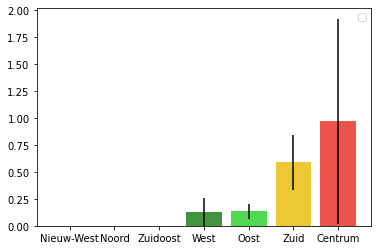

No handles with labels found to put in legend.


Criminal disconnectivity 15


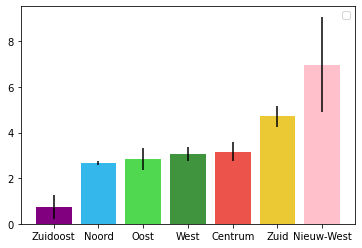

No handles with labels found to put in legend.


Criminal disconnectivity 30


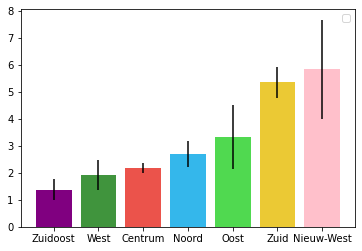

No handles with labels found to put in legend.


Criminal disconnectivity 45


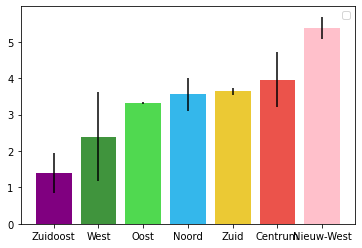

In [63]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict:
    avg_crimes_per_distr_dict_cd, confidence_bounds = get_average_crime_per_distr(output_dict[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_cd.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal disconnectivity {keys}")
    plot_district_means_bar(avg_crimes_per_distr_dict_cd, district_colors,confidence_bounds)

## Criminal risk aversion

In [66]:
num_runs = 10
output_dict_ra = {}

criminal_risk_aversions = [0, 10, 100, 500]

for val in criminal_risk_aversions:
    for run in range(num_runs):
        clear_output()
        print(f"Run {run+1}/{num_runs} of value {val}")
        m = SugarscapeCg(criminal_risk_aversion=val)
        #print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
        output = run_model(m)
        if val in output_dict_ra:
            output_dict_ra[val].append(output)
        else:
            output_dict_ra[val] = [output]
        #outputs.append(output)

Run 3 of value 100


No handles with labels found to put in legend.


Criminal risk aversion 0


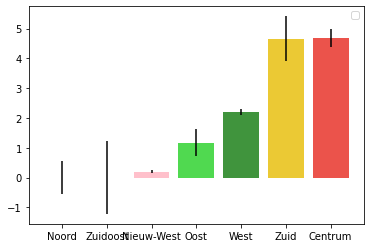

Criminal risk aversion 10


No handles with labels found to put in legend.


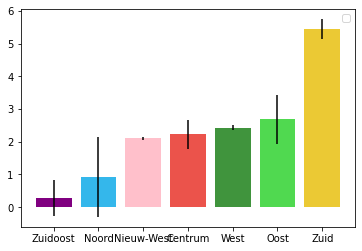

No handles with labels found to put in legend.


Criminal risk aversion 100


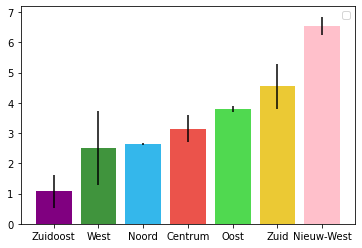

No handles with labels found to put in legend.


Criminal risk aversion 500


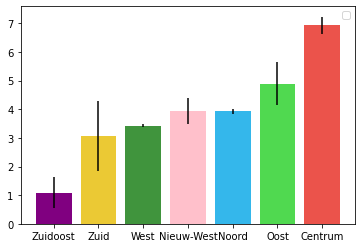

In [ ]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

for keys in output_dict_ra:
    avg_crimes_per_distr_dict_ra, confidence_bounds_ra = get_average_crime_per_distr(output_dict_ra[keys], district_names, 100)
    # Sort colors
    district_colors = []
    for district in avg_crimes_per_distr_dict_ra.keys():
        for dictionary in districts_dict:
            if dictionary['Label'] == district:
                district_colors.append(dictionary['Color'])

    print(f"Criminal risk aversion {keys}")
    plot_district_means_bar(avg_crimes_per_distr_dict_ra, district_colors,confidence_bounds)

In [18]:
print(np.mean(outputs[1]["Zuid"]), np.mean(outputs[1]["Centrum"]))

3.4228855721393034 0.9253731343283582


## Plots

### Criminal wealths

In [19]:
all_wealths = get_data(outputs, 'Criminal Wealth')

# print(all_wealths[0])
print(all_wealths.shape)

(201, 2)


In [20]:
mean_wealths, cis_wealths = get_means_cis(all_wealths)

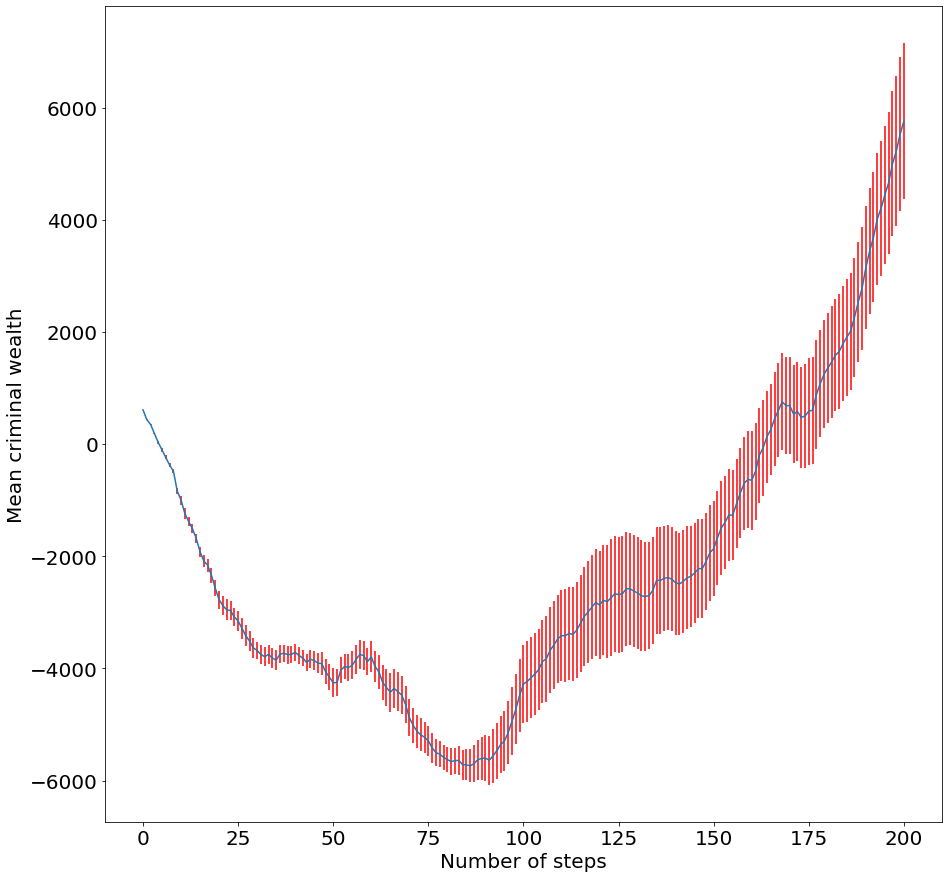

In [21]:
plot_errorbars(mean_wealths, cis_wealths, "Mean criminal wealth")

### Criminals in jail

In [22]:
jail_count = get_data(outputs, 'Criminal in Jail Count')

print(jail_count.shape)

(201, 2)


In [23]:
mean_jail_count, cis_jail_count = get_means_cis(jail_count)

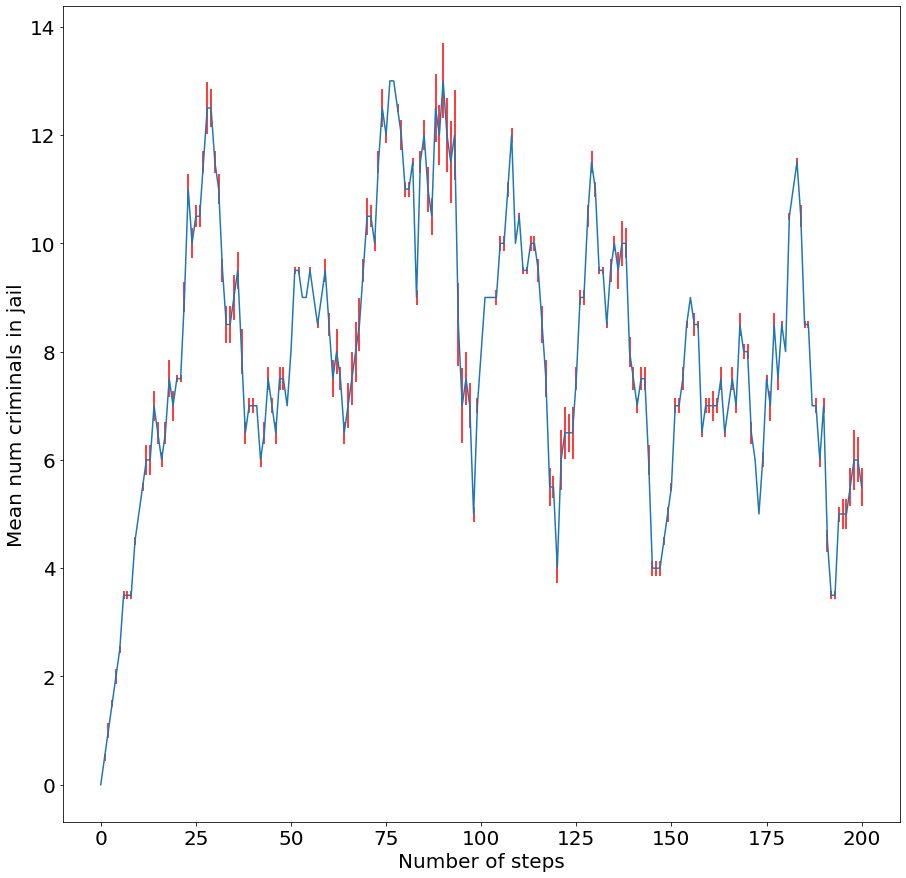

In [24]:
plot_errorbars(mean_jail_count, cis_jail_count, "Mean num criminals in jail")

### Crimes committed

In [25]:
crimes_count = get_data(outputs, 'Crimes commited')

print(crimes_count.shape)

(201, 2)


In [26]:
mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)

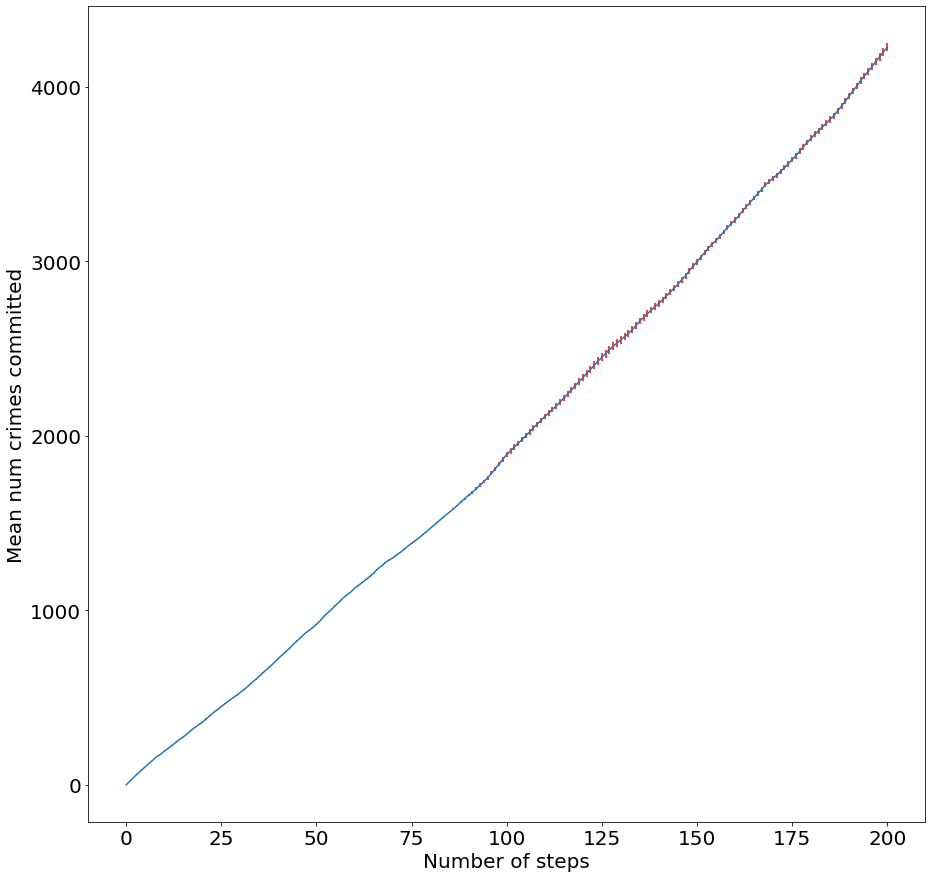

In [27]:
plot_errorbars(mean_crimes_count, cis_crimes_count, "Mean num crimes committed")

### District crimes

In [1]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

avg_crimes_per_distr_dict, confidence_bounds = get_average_crime_per_distr(outputs, district_names, 100)

# Sort colors
district_colors = []
for district in avg_crimes_per_distr_dict.keys():
    print(district)
    for dictionary in districts_dict:
        if dictionary['Label'] == district:
            district_colors.append(dictionary['Color'])

plot_district_means_bar(avg_crimes_per_distr_dict, district_colors, confidence_bounds)

NameError: name 'get_average_crime_per_distr' is not defined

In [29]:
all_district_means = []
all_district_cis = []

for district in district_names:
    crimes_count = get_data(outputs, district)
    mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)
    all_district_means.append(mean_crimes_count)
    all_district_cis.append(cis_crimes_count)

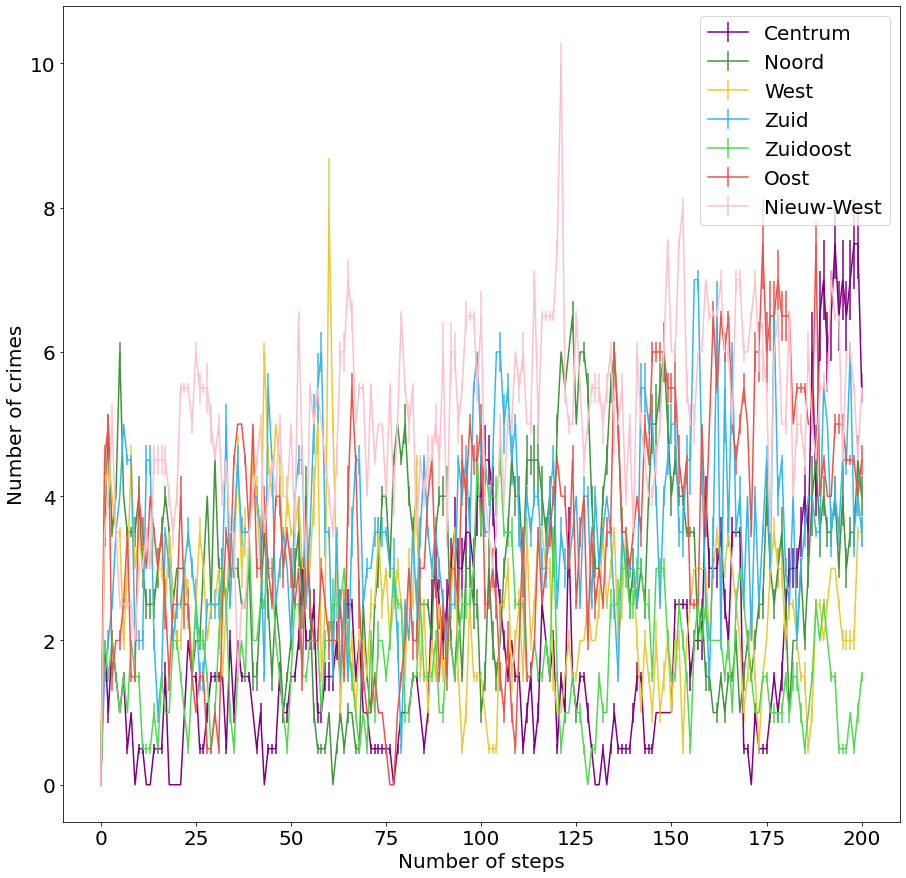

In [30]:
plot_district_crimes(all_district_means, all_district_cis, district_names, district_colors)

In [31]:
# print(len(all_district_means))
# print(len(all_district_means[0]))

# final_district_means = []
# for district in all_district_means:
#     final_district_means.append(district[-1])

# print(final_district_means)

# final_district_cis = []
# for district in all_district_cis:
#     final_district_cis.append(district[-1])

# print(final_district_cis)

In [32]:
# # Sort by size
# sorting = zip(final_district_means, district_names, district_colors)
# final_district_means, district_names, district_colors = zip(*sorted(sorting, key=lambda x : x[0]))

In [33]:
# plot_district_crimes_bar(final_district_means, final_district_cis, district_names, district_colors)